In [1]:
import numpy as np
import pandas as pd
import cupy as cp
import matplotlib.pyplot as plt
import glob
import astropy.units as u
import emcee
import corner
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import KDTree

### results

In [14]:
results = pd.read_csv('mcmc_result.csv')

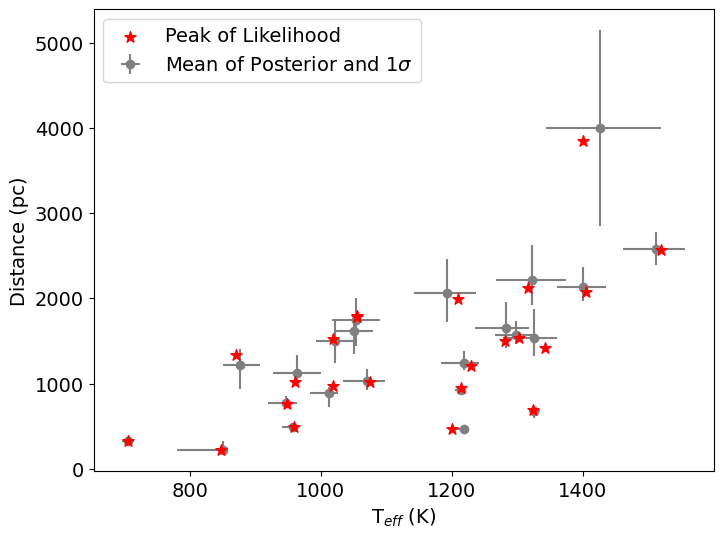

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.errorbar(results['T_eff'], results['distance'], 
    xerr=[results['T_eff_loerr'], results['T_eff_uperr']],
    yerr=[results['distance_loerr'], results['distance_uperr']],
    ls='none', marker='o', c='grey', label='Mean of Posterior and 1$\sigma$'
    )
ax.scatter(results['T_peak'], results['distance_peak'], c='r', marker='*', s=70,
    zorder=10, label='Peak of Likelihood'
    )

# ax.set_xlim(1000, 1100)
# ax.set_yscale('log')
ax.set_xlabel('T$_{eff}$ (K)', fontsize=14)
ax.set_ylabel('Distance (pc)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc='upper left', fontsize=14)

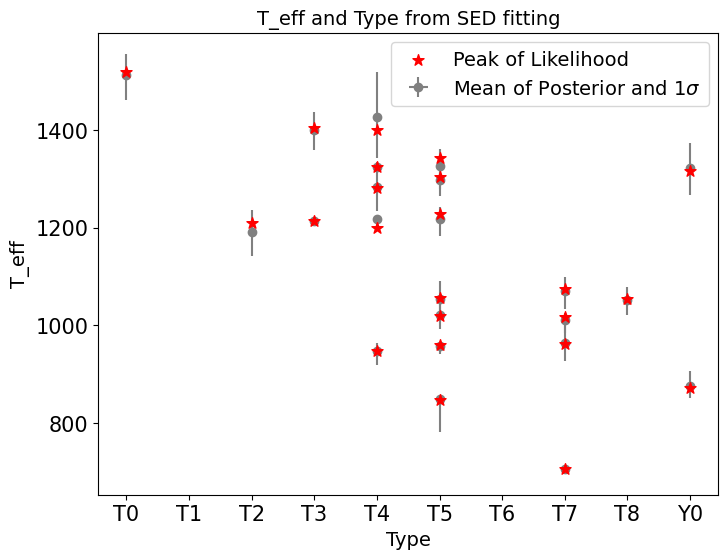

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))


# Plot the data
# ax.hist(results['T_eff'], bins=8, histtype='step', lw=2, color='k')
ax.scatter(results['type'], results['T_peak'], s=70, marker='*', c='r', label='Peak of Likelihood', zorder=10)

ax.errorbar(results['type'], results['T_eff'], 
    yerr=[results['T_eff_loerr'], results['T_eff_uperr']],
    xerr=[0],
    ls='none', marker='o', c='grey', label='Mean of Posterior and 1$\sigma$'
    )

ax.set_xlabel('Type', fontsize=14)
ax.set_xticks(range(10))
ax.set_xticklabels(['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'Y0'])
ax.set_ylabel('T_eff', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.legend(fontsize=14)
ax.set_title('T_eff and Type from SED fitting', fontsize=14)

plt.show()

### read results from CICA and plot

In [2]:
def plot_corner(N, plt_range, full=False):
    
    columns = ["Teff", "log_g", "[M/H]", "d"]
    data = pd.read_csv(f"./results/BD{N}_mcmc.csv"
        , usecols=columns
    )
    
    if full:
        plot_ranges = None
    else:
        plot_ranges = plt_range
    
    figure = corner.corner(
        data,
        labels=[
            "Teff",
            "log(g)",
            "[M/H]",
            "d",
            r"$\Gamma \, [\mathrm{parsec}]$",
        ],
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs={"fontsize": 12},
        range=plot_ranges
    )
    
    title = f"BD{N}"+"\n"+"Peak beam"+"\n"
    for i in range(4):
        histo = np.histogram(data[columns[i]], bins=20, range=plt_range[i])
        max_index = np.argmax(histo[0])
        max_value = (histo[1][max_index]+histo[1][max_index+1])/2
        title+="    "+columns[i]+f": {max_value} \n"
        
    figure.suptitle(title, x=0.6, ha='left', fontsize=16)
    figure.savefig(f"./results/BD{N}corner.png")

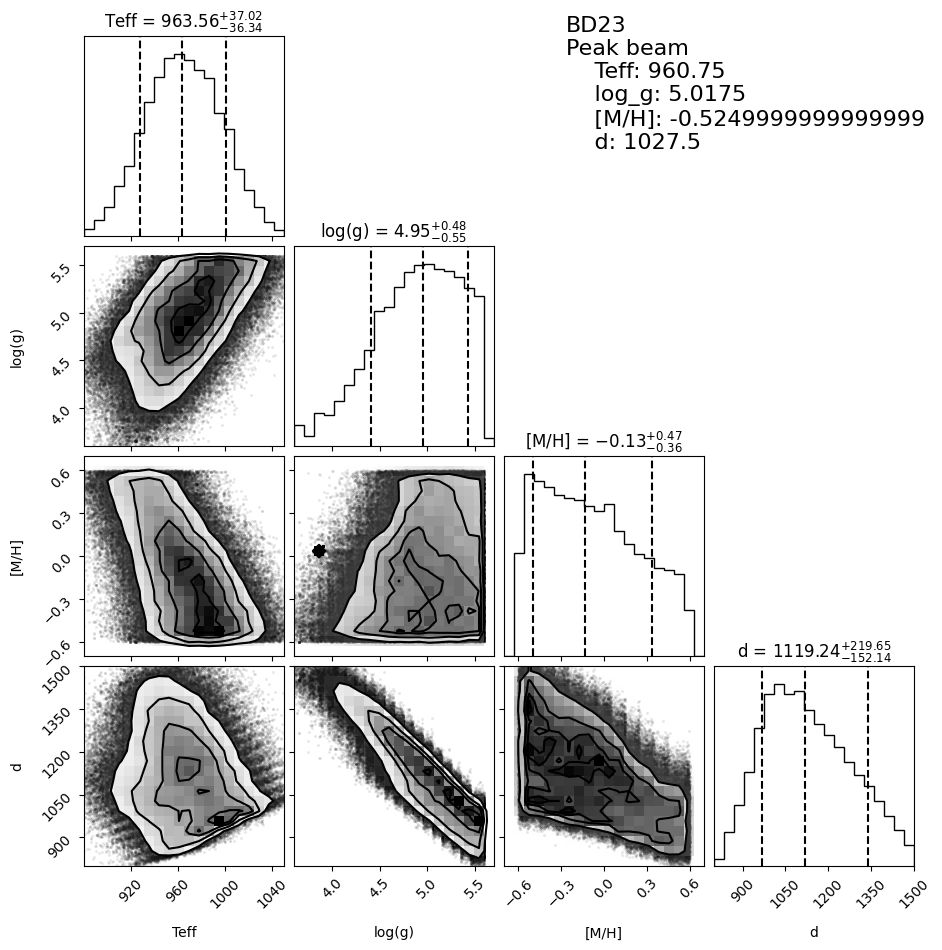

In [21]:
plot_corner(
    '23',
    [(880, 1050), (3.6, 5.7), (-0.7, 0.7), (800, 1500)],
    # full=True
)

Teff peak: 0.43999999999999995


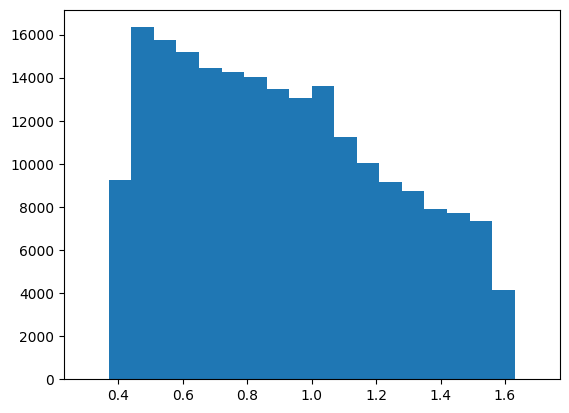

In [12]:
# find peak values

data = pd.read_csv(f"./results/BD23_mcmc.csv"
    , usecols=["Teff", "log_g", "[M/H]", "d"]
)

p1 = plt.hist(data["[M/H]"], bins=20, range=(0.3, 1.7))
# find max bin x-value
max_index = np.argmax(p1[0])
max_value = p1[1][max_index]
print(f"Teff peak: {max_value}")

In [4]:
N = '17'
columns = ["Teff", "log_g", "[M/H]", "d"]
data = pd.read_csv(f"./results/BD{N}_mcmc.csv"
    , usecols=columns
)
data['[M/H]'] = data['[M/H]']-1
data.to_csv(f"./results/BD{N}_mcmc.csv", index=False)

#### test

In [2]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import pandas as pd
# import cupy as cp
import corner
import matplotlib.pyplot as plt
import emcee
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import KDTree
from multiprocessing import Pool

def interpolated_mag(theta, mag_table):
    Teff, log_g, Z, d = theta
    
    # Find the nearest point in the grid
    kdtree = KDTree(mag_table[['Teff', 'log_g', 'Z']])
    dist, points = kdtree.query(theta[:3], 1)
    
    mag = mag_table.iloc[points][['F115W', 'F150W', 'F277W', 'F444W']].values
    
    # Convert fluxes to magnitudes, mag_table is AB magnitude at 10 pc
    Mag = mag + 5 * np.log10(d / 10)
    
    return Mag

def log_likelihood(theta, mag_table, y, yerr):
    model_m = interpolated_mag(theta, mag_table)
    return -0.5 * np.sum(((np.array(y) - np.array(model_m)) / np.array(yerr)) ** 2)  # likelihood function

def log_prior(theta):
    Teff, log_g, Z, d = theta
    if 400 < Teff < 2400 a nd 2.9 < log_g < 5.6 and 0.4 < Z < 1.6 and 9 < d < 4000:  # set a reasonable range of parameters
        return 0.0
    return -np.inf

def log_probability(theta, mag_table, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):  # if the parameter is not reasonable, return -inf (0 possibility)
        return -np.inf
    return lp + log_likelihood(theta, mag_table, y, yerr)

# file_dir = '/cluster/home/yuanchen/JWDT/BD_mcmc/'

mag_table = pd.read_feather('interpolated_ABmag.feather')
observation = pd.read_csv('/home/yuan/JWST/CentralDogma/4_Greed_/final.csv')

magnitudes = observation[['MAG_AUTO_F115W', 'MAG_AUTO_F150W', 'MAG_AUTO_F277W', 'MAG_AUTO_F444W']].values
magerr = observation[['MAGERR_AUTO_F115W', 'MAGERR_AUTO_F150W', 'MAGERR_AUTO_F277W', 'MAGERR_AUTO_F444W']].values
Mobs, Merr = lambda x: magnitudes[x-1], lambda x: magerr[x-1]

n = 2
theta = 1000, 4, 1, 1500
coefficients = np.array([500, 3, 1, 2000])

pos = theta + coefficients * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, pool=pool, args=(mag_table, Mobs(n), Merr(n))
    ) 
    sampler.run_mcmc(pos, 5000, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]/home/yuan/miniconda3/envs/Eva02/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [21:42<00:00,  3.84it/s]


In [3]:
# Remove the burn-in period
flat_samples = sampler.get_chain(discard=600, thin=10, flat=True)
print(flat_samples.shape, type(flat_samples))

# for i in range(ndim):
#     mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
#     q = np.diff(mcmc)
#     print(mcmc[1], q[0], q[1])

(14080, 4) <class 'numpy.ndarray'>


In [11]:
data = pd.DataFrame(flat_samples, columns=['Teff', 'log_g', '[M/H]', 'd'])
data.to_csv('./results/BD01_mcmc.csv')

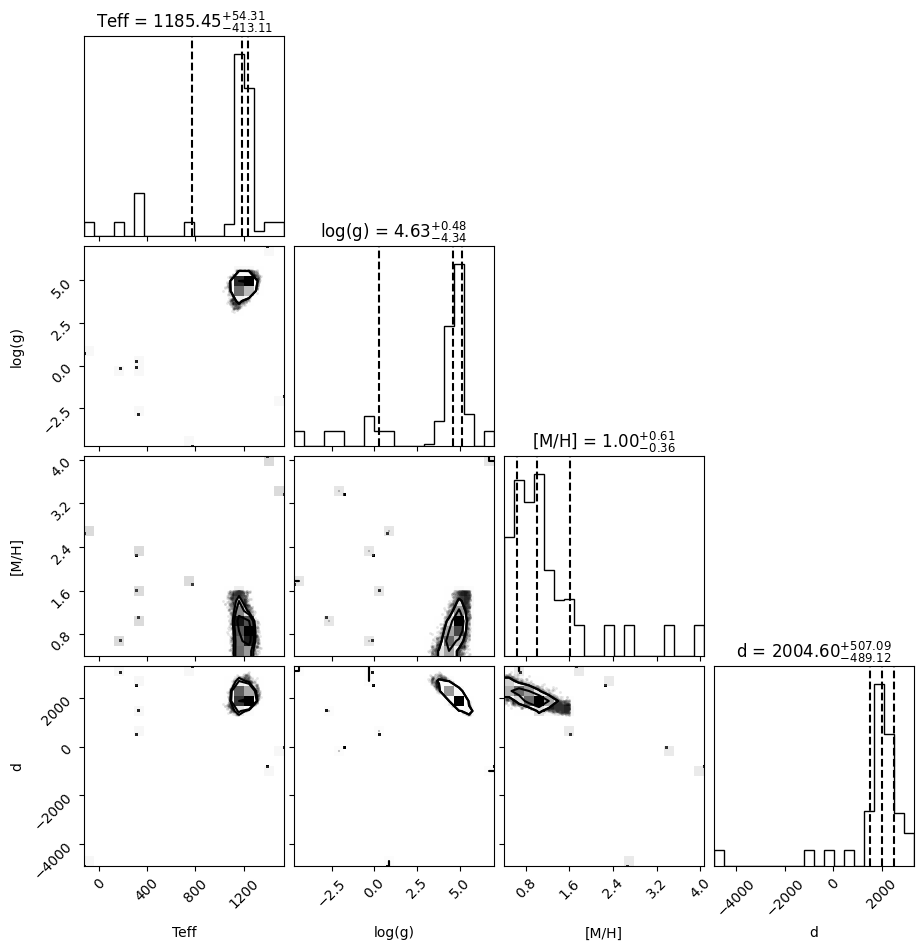

In [12]:
plot_ranges = [(840, 1000), (3.2, 6), (0.3, 1.6), (400, 800)]

# fig = corner.corner(
#     flat_samples, labels=labels, range=plot_ranges
# )

figure = corner.corner(
    data,
    labels=[
        "Teff",
        "log(g)",
        "[M/H]",
        "d",
        r"$\Gamma \, [\mathrm{parsec}]$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    # range=plot_ranges
)

In [1]:

file_dir = '/cluster/home/yuanchen/JWST/BD_mcmc/'

n=5

if n<9:
    print(file_dir+f'results/BD_0{n}chain.png')
else:
    print(file_dir+f'results/BD_{n}chain.png')

/cluster/home/yuanchen/JWST/BD_mcmc/results/BD_05chain.png


### functions

In [5]:
def interpolated_mag(theta, mag_table):
    
    ''' With the input parameters, find the nearest point in the grid and return the BD model magnitudes
    Returns:
    --------
    Mag: numpy array
        Magnitudes in F115W, F150W, F277W, F444W
        
    Parameters:
    -----------
    theta: numpy array
        Teff, log_g, Z, d
    mag_table: pandas DataFrame
        BD model magnitudes table
    ''' 
    
    Teff, log_g, Z, d = theta
    
    # Find the nearest point in the grid
    kdtree = KDTree(mag_table[['Teff','log_g','Z']])
    dist, points=kdtree.query(theta[:3],1)
    
    mag = mag_table.iloc[points][['F115W', 'F150W', 'F277W', 'F444W']].values
    
    # Convert fluxes to magnitudes, mag_table is AB magnitude at 10 pc
        # mag = log10(flux) * -2.5
        # log10(flux/d**2) = log10(flux) - 2*log10(d)
        # mag = -2.5*np.log10(flux) + 5*np.log10(d)
    Mag = mag + 5*np.log10(d/10)
    
    return Mag

def log_likelihood(theta, mag_table, y, yerr):
    Teff, log_g, Z, d = theta
    model_m = interpolated_mag(theta, mag_table)
    return -0.5 * np.sum(((np.array(y) - np.array(model_m))/ np.array(yerr)) ** 2 ) # likelihood function

def log_prior(theta):
    Teff, log_g, Z, d = theta
    if 400 < Teff < 2400 and 2.9 < log_g < 5.6 and 0.4 < Z < 1.6 and 9 < d < 3000: # set a reasonable range of parameters
        return 0.0
    return -np.inf

def log_probability(theta, mag_table, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp): # if the parameter is not reasonable, return -inf (0 possibility)
        return -np.inf
    return lp + log_likelihood(theta, mag_table, y, yerr) # set the probability as maximum likelihood 

In [2]:
# use cupa, cant run on 230
def interpolated_mag(theta, mag_table):
    Teff, log_g, Z, d = theta
    
    # Find the nearest point in the grid
    kdtree = KDTree(mag_table[['Teff', 'log_g', 'Z']])
    dist, points = kdtree.query(theta[:3], 1)
    
    mag = mag_table.iloc[points][['F115W', 'F150W', 'F277W', 'F444W']].values
    
    # Convert fluxes to magnitudes, mag_table is AB magnitude at 10 pc
    Mag = mag + 5 * np.log10(d / 10)
    
    return Mag

def log_likelihood(theta, mag_table, y, yerr):
    model_m = interpolated_mag(theta, mag_table)
    return -0.5 * cp.sum(((cp.array(y) - cp.array(model_m)) / cp.array(yerr)) ** 2)  # likelihood function

def log_prior(theta):
    Teff, log_g, Z, d = theta
    if 400 < Teff < 2400 and 2.9 < log_g < 5.6 and 0.4 < Z < 1.6 and 9 < d < 3000:  # set a reasonable range of parameters
        return 0.0
    return -cp.inf

def log_probability(theta, mag_table, y, yerr):
    lp = log_prior(theta)
    if not cp.isfinite(lp):  # if the parameter is not reasonable, return -inf (0 possibility)
        return -cp.inf
    return lp + log_likelihood(theta, mag_table, y, yerr)

### Run MCMC

In [3]:
mag_table = pd.read_feather('interpolated_ABmag.feather')
observation = pd.read_csv('../CentralDogma/4_Greed_/final.csv')

magnitudes = observation[['MAG_AUTO_F115W', 'MAG_AUTO_F150W', 'MAG_AUTO_F277W', 'MAG_AUTO_F444W']].values
magerr = observation[['MAGERR_AUTO_F115W', 'MAGERR_AUTO_F150W', 'MAGERR_AUTO_F277W', 'MAGERR_AUTO_F444W']].values
Mobs, Merr = lambda x: magnitudes[x-1], lambda x: magerr[x-1]

In [6]:
n = 1
theta = 1000, 4, 1, 1500
coefficients = np.array([500, 3, 1, 2000])

pos = theta + coefficients * np.random.randn(100, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(mag_table, Mobs(n), Merr(n))
) 
sampler.run_mcmc(pos, 20000, progress=True) 

  0%|          | 0/10000 [00:00<?, ?it/s]/home/yuan/miniconda3/envs/Eva02/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/yuan/miniconda3/envs/Eva02/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/yuan/miniconda3/envs/Eva02/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/yuan/miniconda3/envs/Eva02/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 2/10000 [00:00<13:23, 12.45it/s]/home/yuan/miniconda3/envs/Eva02/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subt

State([[ 9.65155096e+02  5.48766621e+00  5.21172354e-01  4.92840942e+02]
 [ 9.71645713e+02  5.48906669e+00  5.41052408e-01  4.96527809e+02]
 [ 1.21999945e+03  7.06118887e+00  2.69825350e+00 -1.44158971e+03]
 [ 7.74908094e+02 -7.47955605e-01  1.14700576e+00  1.04543242e+02]
 [ 9.60941957e+02  5.53650804e+00  4.40907662e-01  4.91976987e+02]
 [ 9.67787044e+02  5.54175262e+00  4.44781608e-01  4.93824088e+02]
 [ 9.56314400e+02  5.58474911e+00  4.73239295e-01  4.86153714e+02]
 [ 9.52535828e+02  5.55562320e+00  5.21086601e-01  4.86859502e+02]
 [ 9.62455297e+02  5.49111442e+00  4.51059625e-01  4.89195071e+02]
 [ 9.59868866e+02  5.46428056e+00  5.42288231e-01  4.88944202e+02]
 [ 9.42808015e+02  5.55310252e+00  6.21127728e-01  4.77586250e+02]
 [ 9.64597567e+02  5.58393440e+00  4.04614586e-01  4.94930229e+02]
 [ 9.66548573e+02  5.51893780e+00  5.43854191e-01  4.94489104e+02]
 [ 9.62098810e+02  5.50061273e+00  4.42950807e-01  4.90687848e+02]
 [ 1.74195917e+03  7.57872437e-01  2.44742024e+00 -5.277

In [7]:
tau = sampler.get_autocorr_time()
print(tau)      
# This suggests that only about 40 steps are needed for the chain to “forget” where it started.
# 32 walkers, 5000 steps, 4 parameters, takes 1 hour to run in 140.114.94.230

[nan nan nan nan]


/home/yuan/miniconda3/envs/Eva02/lib/python3.11/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


Text(0.5, 0, 'step number')

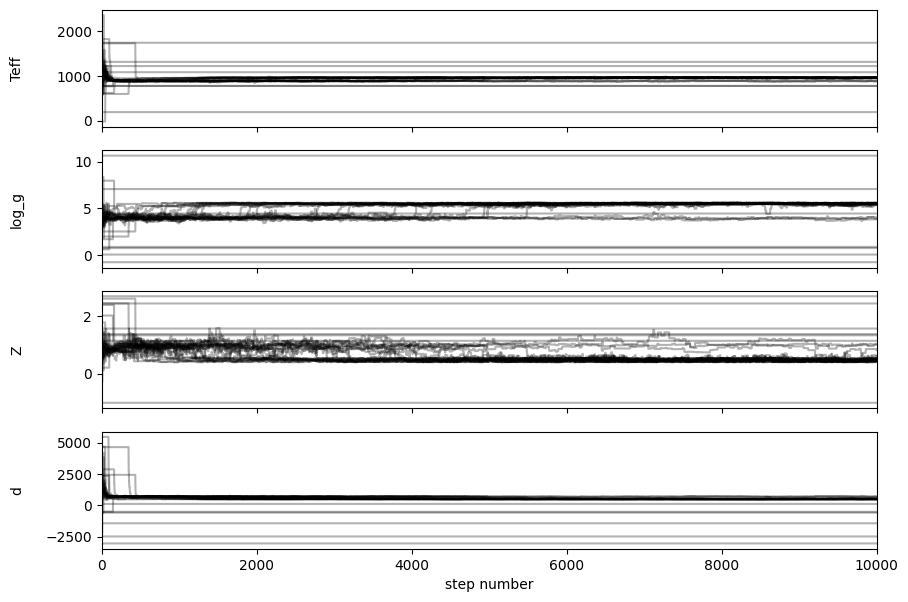

In [8]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()       # get 32 values for each time (within 5000)
labels = ["Teff", "log_g", "Z", "d"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

(32000, 4)


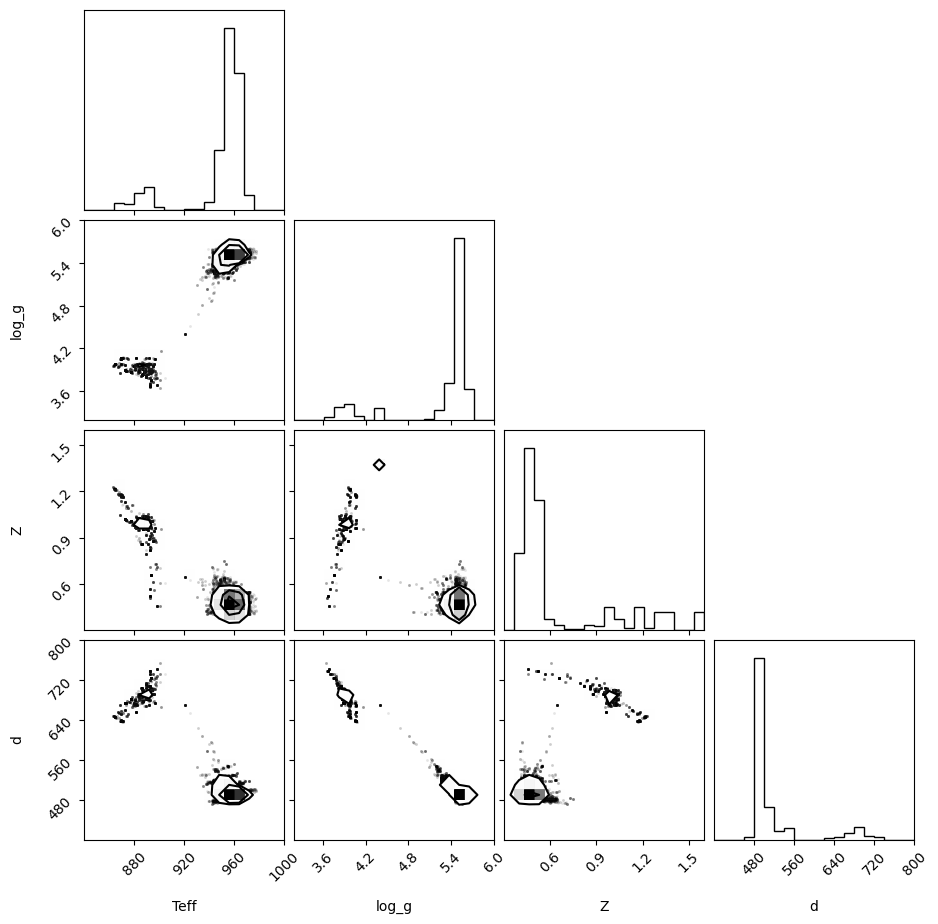

In [15]:
import corner

# Let’s discard the initial 100 steps, thin by about half the autocorrelation time (15 steps), and flatten the chain so that we have a flat list of samples
flat_samples = sampler.get_chain(discard=8000, thin=2, flat=True)
print(flat_samples.shape)

plot_ranges = [(840, 1000), (3.2, 6), (0.3, 1.6), (400, 800)]

fig = corner.corner(
    flat_samples, labels=labels, range=plot_ranges
)

In [18]:
type(sampler)

emcee.ensemble.EnsembleSampler

In [12]:
theta=1300,1780,7,4500
print(theta[0])
print(type(theta))
pos = theta + 1e3*np.random.randn(32,4)  
print(type(pos))      

1300
<class 'tuple'>
<class 'numpy.ndarray'>


In [27]:
theta = 1100, 4.25, 1.0, 2178
interpolated_mag(theta, mag_table)

array([26.855605, 27.473055, 27.970555, 26.357405])

In [25]:
theta = 1000, 4.5, 0.6, 600
interpolated_mag(theta, mag_table)

array([24.61932187, 25.42002187, 26.23117187, 23.95257187])

In [11]:
mag_table

Teff  log_g    Z      F115W      F150W      F277W      F444W  \
0        400.0    3.0  0.5  22.456816  23.941816  23.846566  17.565566   
1        400.0    3.0  0.6  22.353566  23.971366  23.875616  17.571766   
2        400.0    3.0  0.7  22.250316  24.000916  23.904666  17.577966   
3        400.0    3.0  0.8  22.147066  24.030466  23.933716  17.584166   
4        400.0    3.0  0.9  22.043816  24.060016  23.962766  17.590366   
...        ...    ...  ...        ...        ...        ...        ...   
114681  2400.0    5.5  1.1  12.723066  12.634866  13.400016  13.365116   
114682  2400.0    5.5  1.2  12.697816  12.627166  13.372966  13.346166   
114683  2400.0    5.5  1.3  12.672566  12.619466  13.345916  13.327216   
114684  2400.0    5.5  1.4  12.647316  12.611766  13.318866  13.308266   
114685  2400.0    5.5  1.5  12.622066  12.604066  13.291816  13.289316   

           mass   R/Rsun  
0         0.670  0.13250  
1         0.676  0.13308  
2         0.682  0.13366  
3         0.688  0.13424  
4         0.694  0.13482  
...         ...      ...  
114681  100.442  0.09114  
114682  102.314  0.09198  
114683  104.186  0.09282  
114684  106.058  0.09366  
114685  107.930  0.09450  

[114686 rows x 9 columns]

In [ ]:
### interpolate templates

#### interpolate

In [7]:
ABmag_table = pd.read_csv('ABmag_table.csv')

Teff_new_grid = np.linspace(400, 2400, 400+1)
log_g_new_grid = np.linspace(3, 5.5, 25+1)
Z_new_grid = np.linspace(0.5, 1.5, 10+1)

#### 3D lets go

In [8]:
# Create a meshgrid for Teff, log_g, and Z
X, Y, Z = np.meshgrid(Teff_new_grid, log_g_new_grid, Z_new_grid, indexing='ij')

# Combine Teff, log(g), and Z into a single array of points for interpolation
points = ABmag_table[['Teff', 'log(g)', 'Z']].values
values = ABmag_table[['F115W', 'F150W', 'F277W', 'F444W', 'mass', 'R/Rsun']].values

# Perform the 3D interpolation
interp = LinearNDInterpolator(points, values)

# Create the grid of points where we want to interpolate
grid_points = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T

# Interpolate the data
interpolated_values = interp(grid_points)

# Check for NaNs in the interpolated data
if np.any(np.isnan(interpolated_values)):
    print("Interpolation resulted in NaNs. Adjust grid or data.")
else:
    # Reshape the interpolated values to the shape of the grid
    interpolated_values = interpolated_values.reshape(len(Teff_new_grid), len(log_g_new_grid), len(Z_new_grid), -1)
    
    # Flatten the grids and interpolated data
    Teff_flat = X.flatten()
    log_g_flat = Y.flatten()
    Z_flat = Z.flatten()
    F115W_flat = interpolated_values[..., 0].flatten()
    F150W_flat = interpolated_values[..., 1].flatten()
    F277W_flat = interpolated_values[..., 2].flatten()
    F444W_flat = interpolated_values[..., 3].flatten()
    mass_flat = interpolated_values[..., 4].flatten()
    R_flat = interpolated_values[..., 5].flatten()
    
    # Create a DataFrame with the flattened data
    data = {
        'Teff': Teff_flat,
        'log_g': log_g_flat,
        'Z': Z_flat,
        'F115W': F115W_flat,
        'F150W': F150W_flat,
        'F277W': F277W_flat,
        'F444W': F444W_flat,
        'mass': mass_flat,
        'R/Rsun': R_flat
    }
    
    df = pd.DataFrame(data)
    
    # Save the DataFrame to a Feather file
    df.to_feather('interpolated_ABmag.feather')
    
    print("Interpolation and saving completed successfully.")


Interpolation and saving completed successfully.


#### 2D test

In [25]:
X, Y = np.meshgrid(Teff_new_grid, log_g_new_grid)

# ABmag_table_zslice = ABmag_table[ABmag_table['Z'] == 0.5]
interp = LinearNDInterpolator(ABmag_table[['Teff', 'log(g)']].values, 
                            ABmag_table[['F115W', 'F150W', 'F277W', 'F444W']].values)
Z = interp(X, Y)

Teff_flat = X.flatten()
log_g_flat = Y.flatten()
Z_flat = Z.reshape(-1, 4)

# Create a DataFrame with the flattened data
data = {
    'Teff': Teff_flat,
    'log_g': log_g_flat,
    'F115W': Z_flat[:, 0],
    'F150W': Z_flat[:, 1],
    'F277W': Z_flat[:, 2],
    'F444W': Z_flat[:, 3]
}

df = pd.DataFrame(data)

# Save the DataFrame to a Feather file
# df.to_feather(f'interpolated_ABmag.feather')

[[[21.83756562 24.19081562 24.08531562 17.63156562]
  [21.69886562 23.99546562 23.93321562 17.56606562]
  [21.56016562 23.80011562 23.78111562 17.50056562]
  ...
  [ 9.97869062  9.99676562 10.36434062 10.44601562]
  [ 9.96037812  9.97679062 10.34445312 10.43041562]
  [ 9.94206562  9.95681562 10.32456562 10.41481562]]

 [[21.88609503 24.13356072 24.10541366 17.65999699]
  [21.74739503 23.93821072 23.95331366 17.59449699]
  [21.60869503 23.74286072 23.80121366 17.52899699]
  ...
  [10.08444382 10.10368976 10.47979339 10.55893129]
  [10.08766648 10.10564485 10.4851697  10.56638326]
  [10.09088915 10.10759994 10.49054601 10.57383523]]

 [[21.93462445 24.07630582 24.1255117  17.68842837]
  [21.79592445 23.88095582 23.9734117  17.62292837]
  [21.7295215  23.69242543 23.81329405 17.55811954]
  ...
  [10.23326735 10.25447407 10.64577378 10.7179509 ]
  [10.23649001 10.25642916 10.65115009 10.72540287]
  [10.23971268 10.25838425 10.65652641 10.73285484]]

 ...

 [[23.22696562 23.84571562 25.1647

#### troble shooting

In [20]:
print(ABmag_table[['Teff', 'log(g)']].describe())
print(f'Teff_new_grid range: {Teff_new_grid.min()} to {Teff_new_grid.max()}')
print(f'log_g_new_grid range: {log_g_new_grid.min()} to {log_g_new_grid.max()}')


              Teff       log(g)
count  1131.000000  1131.000000
mean    971.799293     4.216414
std     657.485384     0.810721
min     200.000000     3.000000
25%     425.000000     3.505000
50%     750.000000     4.250000
75%    1500.000000     5.000000
max    2401.000000     5.500000
Teff_new_grid range: 400.0 to 2400.0
log_g_new_grid range: 1000.0 to 316227.7660168379


In [21]:
print(f'Number of NaNs in interpolated Z: {np.isnan(Z).sum()}')

Number of NaNs in interpolated Z: 41704


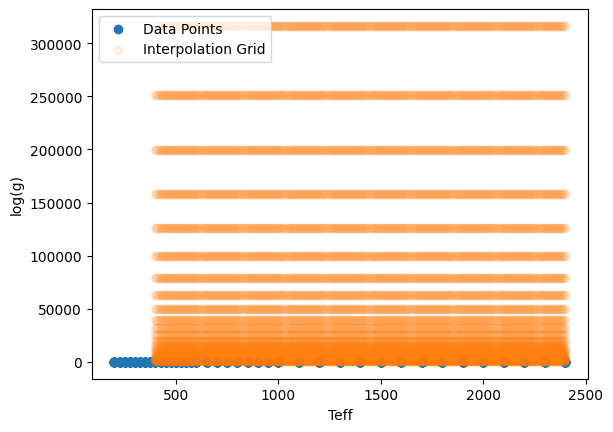

In [23]:
plt.scatter(ABmag_table['Teff'], ABmag_table['log(g)'], label='Data Points')
plt.scatter(X.flatten(), Y.flatten(), label='Interpolation Grid', alpha=0.1)
plt.xlabel('Teff')
plt.ylabel('log(g)')
plt.legend()
plt.show()

In [5]:
# read feather file
ABmag_table = pd.read_feather('interpolated_ABmag_0.5Z.feather')

In [6]:
ABmag_table


Teff          log_g  F115W  F150W  F277W  F444W
0       400.000000    1000.000000    NaN    NaN    NaN    NaN
1       404.545455    1000.000000    NaN    NaN    NaN    NaN
2       409.090909    1000.000000    NaN    NaN    NaN    NaN
3       413.636364    1000.000000    NaN    NaN    NaN    NaN
4       418.181818    1000.000000    NaN    NaN    NaN    NaN
...            ...            ...    ...    ...    ...    ...
11461  2381.818182  316227.766017    NaN    NaN    NaN    NaN
11462  2386.363636  316227.766017    NaN    NaN    NaN    NaN
11463  2390.909091  316227.766017    NaN    NaN    NaN    NaN
11464  2395.454545  316227.766017    NaN    NaN    NaN    NaN
11465  2400.000000  316227.766017    NaN    NaN    NaN    NaN

[11466 rows x 6 columns]

#### interpolate test

In [10]:
subset = ABmag_table[:78]

In [11]:
Teff_grid = np.linspace(200, 2400, 44+1)
log_g_grid = np.linspace(3, 3.255, 50)

X, Y = np.meshgrid(Teff_grid, log_g_grid)
interp = LinearNDInterpolator(subset[['Teff', 'log(g)']].values, 
                            subset[['F115W', 'F150W', 'F277W', 'F444W']].values)
Z = interp(X, Y)

In [12]:
Teff_flat = X.flatten()
log_g_flat = Y.flatten()
Z_flat = Z.reshape(-1, 4)

In [6]:
Teff_flat

array([ 200.,  250.,  300., ..., 2300., 2350., 2400.])

In [13]:
Z_flat[:, 0]

array([35.33556562, 30.81606562, 27.40056562, ..., 10.66006562,
       10.49081562, 10.32156562])

In [14]:
Z_flat

array([[35.33556562, 33.46381562, 32.66306562, 21.31131562],
       [30.81606562, 30.20406562, 29.60506562, 20.02281562],
       [27.40056562, 27.76656562, 27.23981562, 19.02931562],
       ...,
       [10.66006562, 10.71281562, 11.11956562, 11.10881562],
       [10.49081562, 10.52706562, 10.93369062, 10.96456562],
       [10.32156562, 10.34131562, 10.74781562, 10.82031562]])

In [88]:
Z

array([[[35.33556562, 33.46381562, 32.66306562, 21.31131562],
        [30.81606562, 30.20406562, 29.60506562, 20.02281562],
        [27.40056562, 27.76656562, 27.23981562, 19.02931562],
        ...,
        [10.30831562, 10.35631562, 10.72231562, 10.72681562],
        [10.12519062, 10.15656562, 10.52344062, 10.57081562],
        [ 9.94206562,  9.95681562, 10.32456562, 10.41481562]],

       [[35.33410134, 33.45691766, 32.66334623, 21.31256562],
        [30.81481052, 30.19794828, 29.60636664, 20.02430032],
        [27.40006562, 27.76137174, 27.24167787, 19.03093807],
        ...,
        [10.31549419, 10.36359113, 10.73042277, 10.73461154],
        [10.13293552, 10.16441256, 10.53207838, 10.57909113],
        [ 9.94981052,  9.96466256, 10.33320338, 10.42309113]],

       [[35.33263705, 33.4500197 , 32.66362685, 21.31381562],
        [30.81355542, 30.19183093, 29.60766766, 20.02578501],
        [27.39956562, 27.75617787, 27.24354011, 19.03256052],
        ...,
        [10.32267277, 10.37

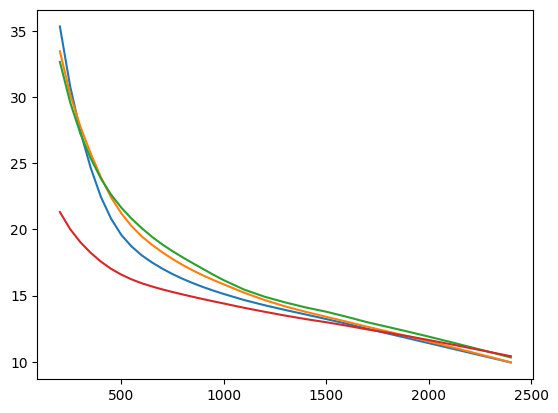

In [81]:
plt.plot(Teff_grid, Z[0])

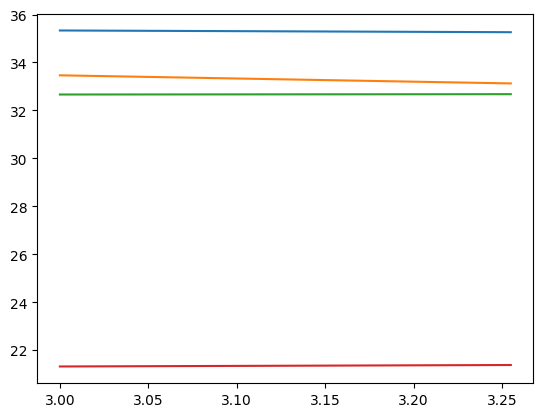

In [103]:
plt.plot(log_g_grid, Z[:, 0])

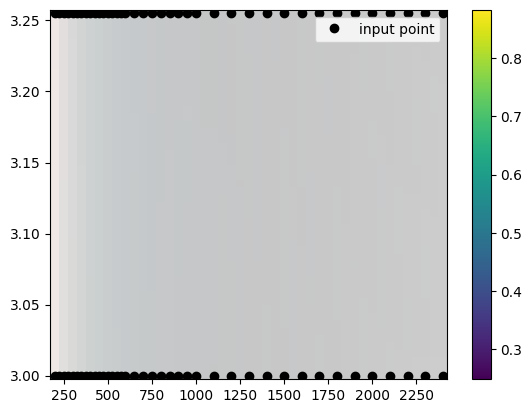

In [79]:
plt.pcolormesh(X, Y, Z/40)
plt.plot(subset['Teff'].values, subset['log(g)'].values, "ok", label="input point")
plt.legend()
plt.colorbar()
# plt.axis("equal")
plt.show()

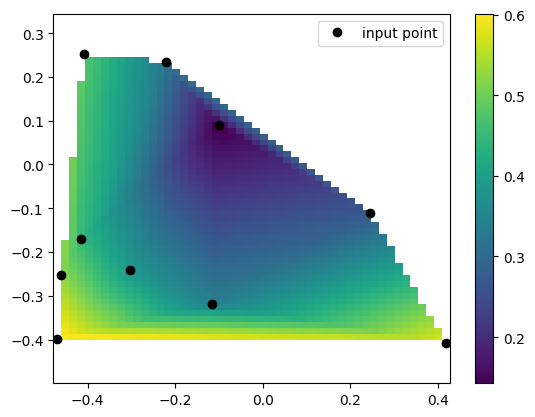

In [75]:
from scipy.interpolate import LinearNDInterpolator
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()
x = rng.random(10) - 0.5
y = rng.random(10) - 0.5
z = np.hypot(x, y)
X = np.linspace(min(x), max(x))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
interp = LinearNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)
plt.pcolormesh(X, Y, Z, shading='auto')
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

In [76]:
Z.shape

(50, 50)

In [ ]:
for i in range(len(Z_grid)):
    
    

#### make seed

In [4]:
from mcmc4bd import read_flux_table

dir1 = '/home/yuan/LePhare/lephare_dev/sed/STAR/'
flux_tables = glob.glob(dir1+'Sonora_Bobcat/flux_table/*')
colums = ['Teff', 'log(g)', 'mass', 'R/Rsun', 'F115W', 'F150W', 'F277W', 'F444W']

ABmag = lambda flux: -2.5*(flux-np.log10(3631000)) # convert flux to magnitude, flux unit: log(mJy)
flux_table = read_flux_table(flux_tables[0])[colums]
flux_table[['F115W', 'F150W', 'F277W', 'F444W']] = flux_table[['F115W', 'F150W', 'F277W', 'F444W']].apply(ABmag)
flux_tablep = read_flux_table(flux_tables[1])[colums]
flux_tablep[['F115W', 'F150W', 'F277W', 'F444W']] = flux_tablep[['F115W', 'F150W', 'F277W', 'F444W']].apply(ABmag)
flux_tablem = read_flux_table(flux_tables[2])[colums]
flux_tablem[['F115W', 'F150W', 'F277W', 'F444W']] = flux_tablem[['F115W', 'F150W', 'F277W', 'F444W']].apply(ABmag)

flux_table['Z'] = 1.0
flux_tablep['Z'] = 1.5
flux_tablem['Z'] = 0.5

m1 = flux_tablem.merge(flux_table, how='outer')
m2 = m1.merge(flux_tablep, how='outer')
m2.to_csv('ABmag_table.csv', index=False)